In [1]:
import numpy as np
from scipy import interp
import glob
import networkx as nx
import re
import graspy
from graspy.embed import OmnibusEmbed
from graspy.embed import ClassicalMDS
import seaborn as sns
import pandas as pd
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, roc_curve, auc
import matplotlib.pyplot as plt
from graspy.plot import pairplot
%matplotlib inline

In [2]:
# functions
def isolate_number_in_the_filename(file):
    subject_info = re.findall(r'\d+', file)
    return subject_info[0]


def query_columns(df, subid):
    subid = subid[2:]
    age = df.query('SUBID == {}'.format(subid))['AGE_AT_SCAN_1'].tolist()[0]
    sex = df.query('SUBID == {}'.format(subid))['SEX'].tolist()[0]
    return age, sex


def save_patients_data(ids, ages, sexes):
    # Create pandas dataframe from lists using dictionary
    d = {'ID': ids, 'Age': ages, 'Sex': sexes}
    patient_data = pd.DataFrame(d)
    return patient_data

In [3]:
df = pd.read_csv("/Users/zhangsiqi/Downloads/HNU1.csv")
allLines = []
ids = []
ages = []
sexes = []

In [4]:
for file in glob.glob("/Users/zhangsiqi/Desktop/brain/*.ssv"):
    # Isolate 7 digit number in the filename
    # Look string manipulation in python
    subid = isolate_number_in_the_filename(file)
    # Use the id to the patient's sex and age from df
    # Look up how to query tables in pandas
    age, sex = query_columns(df, subid)
    # Save values for age and sex
    # Save the values in a pandas dataframe
    # Store patient id, age, and sex
    ages.append(age)
    ids.append(subid)
    sexes.append(sex)
    # Read files
    G = nx.read_weighted_edgelist(file)
    allLines.append(G)

In [5]:
patient_data = save_patients_data(ids, ages, sexes)

In [6]:
# embedding multiple graphs
embedder = OmnibusEmbed()
Zhat = embedder.fit_transform(allLines)

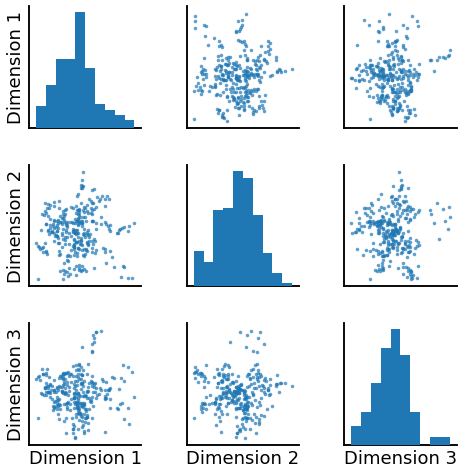

In [7]:
cmds = ClassicalMDS()
cmds_embedding = cmds.fit_transform(Zhat)
plot = pairplot(cmds_embedding)

In [8]:
cmds_df = pd.DataFrame(cmds_embedding, columns=["Dimension {}".format(i) for i in range(cmds_embedding.shape[1])])
cmds_df.head()

,Dimension 0,Dimension 1,Dimension 2
0,-15.617064,-24.233845,-7.788965
1,-1.999253,-44.630275,-5.027785
2,-32.924351,-51.079627,26.243356
3,-8.842550,1.178060,22.066516
4,103.371713,-45.793887,19.831237


In [9]:
X = cmds_embedding
y = patient_data['Sex']
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy of Sex:", metrics.accuracy_score(y_test, y_pred))

Accuracy of Sex: 0.8666666666666667
Accuracy of Sex: 0.9333333333333333
Accuracy of Sex: 0.8
Accuracy of Sex: 0.8
Accuracy of Sex: 0.7666666666666667
Accuracy of Sex: 0.9
Accuracy of Sex: 0.8333333333333334
Accuracy of Sex: 0.9
Accuracy of Sex: 0.9
Accuracy of Sex: 0.9


/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel()

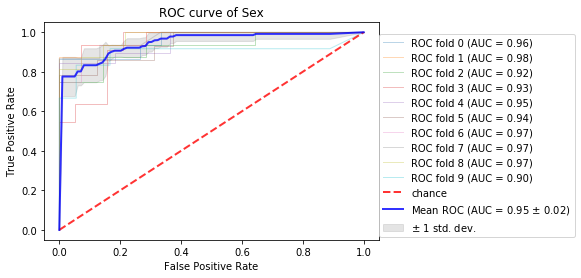

In [12]:
X = cmds_embedding
y = patient_data['Sex']
kf = KFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

i = 0
for train, test in kf.split(X):
    clf = RandomForestClassifier(n_estimators=150)
    clf = clf.fit(X[train], y[train])
    probas_ = clf.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:,1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Sex')
plt.legend(loc="lower right", bbox_to_anchor=(1.6, -0.01))
plt.savefig("my_figure_5.png", bbox_inches='tight', dpi=300, )